This is a companion script for the dataset published with the paper:

Basal ganglia output coding - entopeduncular nucleus - of contextual kinematics and reward in the freely moving mouse

Anil K Verma-Rodríguez, Josué O Ramírez-Jarquín, Román Rossi-Pool, Fatuel Tecuapetla
eLife, 2025


In [1]:
import os 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from utils import explore_hdf5, make_grid, align_spikes


In [2]:
notebook_dir = os.getcwd()

# Get the path to the parent directory
project_path, _ = os.path.split( notebook_dir)

data_folder_path = os.path.join( project_path, 'data')

session_files = [f for f in os.listdir(data_folder_path) if f.endswith(".h5")]

# Print available session files
print("Available session files:", session_files)

Available session files: ['20201214_4302_session_data.h5', '20201125_4293_session_data.h5', '20201129_4297_session_data.h5', '20210729_4659_session_data.h5', '20210726_4661_session_data.h5', '20210808_4659_session_data.h5', '20210730_4661_session_data.h5', '20210708_4661_session_data.h5', '20210706_4661_session_data.h5', '20210903_4661_session_data.h5', '20210724_4661_session_data.h5', '20210714_4661_session_data.h5', '20201113_4293_session_data.h5', '20201123_4293_session_data.h5', '20210903_4659_session_data.h5', '20201118_4293_session_data.h5', '20210729_4661_session_data.h5', '20211202_4662_session_data.h5', '20210720_4659_session_data.h5', '20201114_4297_session_data.h5', '20201126_4293_session_data.h5', '20210716_4661_session_data.h5', '20210808_4661-2_session_data.h5', '20210722_4659_session_data.h5', '20201119_4297_session_data.h5', '20210713_4659_session_data.h5', '20211204_4662_session_data.h5', '20210813_4661_session_data.h5', '20210924_4662_session_data.h5', '20210823_4659_

In [3]:
my_file = os.path.join( data_folder_path, '20211202_4662_session_data.h5')

explore_hdf5(my_file)

Exploring /averma/rawData/sendelife/data/20211202_4662_session_data.h5...

Contents:

Group: /trial_data
  Type: DataFrame | Shape: (549, 35)
  Columns: ['index', 'sessid', 'stim_finalFreq', 'false_alarm', 'turn_side']...

Group: /video_tracking
  Type: DataFrame | Shape: (658787, 58)
  Columns: [('timestamp', ''), ('C3', 'x'), ('C3', 'y'), ('C3', 'likelihood'), ('hindlimbRight', 'x')]...

Group: /video_tracking_vars
  Type: DataFrame | Shape: (658787, 13)
  Columns: ['head_speed', 'body_speed', 'head_acc', 'body_acc', 'angVel']...

Group: /spike_times/ch11_unit1
  Type: DataFrame | Shape: (617525, 1)
  Columns: ['timestamps']

Group: /spike_times/ch13_unit1
  Type: DataFrame | Shape: (180259, 1)
  Columns: ['timestamps']

Group: /spike_times/ch16_unit1
  Type: DataFrame | Shape: (241579, 1)
  Columns: ['timestamps']

Group: /spike_times/ch2_unit1
  Type: DataFrame | Shape: (13697, 1)
  Columns: ['timestamps']

Group: /spike_times/ch5_unit1
  Type: DataFrame | Shape: (333968, 1)
  Colu

Extract data

In [4]:

spike_times_dict = {}
with pd.HDFStore(my_file,  mode='r') as store:
    
    video_tracking = store.select('video_tracking')
    
    video_tracking_vars= store.select('video_tracking_vars')
    
    trials= store.select('trial_data')
    
    for key in store.keys():
        if key.startswith('/spike_times'):
            spike_times_dict[key.split('/')[-1]] = store.select(key)

Plot 30 minutes of tracking data

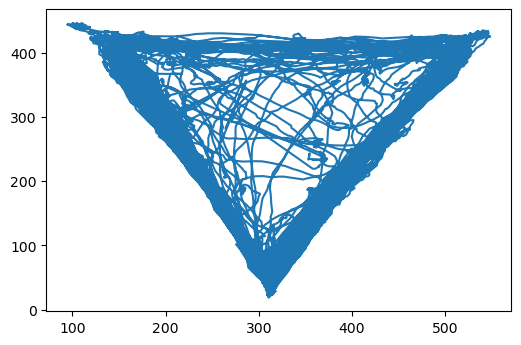

In [5]:

sampling_rate_ephys= 30000
sampling_rate_video= 75

final_frame_to_plot= 30 * 60 * sampling_rate_video

plt.figure(dpi=100)
plt.plot( video_tracking.loc[:final_frame_to_plot,('snout','x')], video_tracking.loc[:final_frame_to_plot,('snout','y')] )
plt.show()

Plot a raster plot, together with a video-derived variable (paw position)

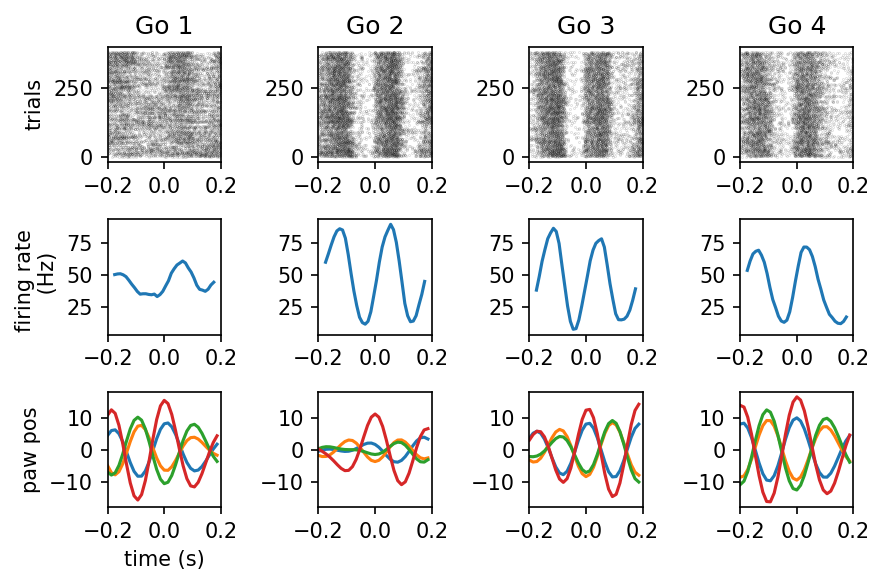

In [6]:
fig, ax= plt.subplots(3,4, tight_layout=True, dpi=150)

for i in range(4):
    
    events=trials.loc[:,'timestamp_pawPeak_R'+str(i+1)].dropna().values
    
    
    params= {'sampling_frequency': 30000 , # Sampling frequency of spikes and events.
         'event_times': events , # Event timestamps.
         'spike_times': spike_times_dict['ch13_unit1']['timestamps'].values , # Spike timestamps.
         'time_before_event': -.2 , # Time before events (in seconds).
         'time_after_event': .2 , # Time after events (in seconds).
         'bin_size': 0.05, # Bin size for histogram (in seconds).
         'sliding_window':0.01, # Sliding window size (in seconds).
    }
    
    out= align_spikes(params)
    
    
    ax[0][i].plot( out['aligned_spikes'] / sampling_rate_ephys, out['event_indices'], 'k.', ms=.1)
    ax[0][i].set_xlim([-.2,.2])
    ax[0][i].set_title('Go '+str(i+1))
    
    
    
    # ax[1][i].plot( out[4], out[0] )
    ax[1][i].plot( out['time'], out['avg_spike_rate'] )
    ax[1][i].set_xlim([-.2,.2])

    ax[1][i].sharey( ax[1][0])
    
    
    for paw in range(1,5):
        
        frame_events= trials.loc[:,'frame_pawPeak_G'+str(i+1)].dropna().values
        frame_range= np.arange( -.2*sampling_rate_video, .2*sampling_rate_video)

        frame_time= frame_range / sampling_rate_video


        grid= make_grid( frame_range, frame_events )

        
        video_tracking_vars[f'paw{paw}_pos'].values[grid]
    
    
    
        ax[2][i].plot( frame_time, video_tracking_vars[f'paw{paw}_pos'].values[grid].mean(0))
        ax[2][i].sharey( ax[2][0])
        ax[2][i].set_xlim([-.2,.2])
        
    if i==0:
        ax[0][i].set_ylabel('trials')
        ax[1][i].set_ylabel('firing rate \n (Hz)')
        ax[2][i].set_ylabel('paw pos')
        ax[2][i].set_xlabel('time (s)')
